<a href="https://colab.research.google.com/github/Renn-1205/Dynamic-quote-generator/blob/main/Message%20Customer%20support%20Train%20model%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip install nltk seaborn
import nltk
nltk.download('punkt')

import pandas as pd
import numpy as np

# Load dataset (it’s CSV-formatted)
df = pd.read_csv("message,sentiment.json")
df = df.dropna(subset=["message", "sentiment"])
df["message"] = df["message"].astype(str).str.strip()
df["sentiment"] = df["sentiment"].str.strip().str.lower()

print(df.head())
print("Class counts:\n", df["sentiment"].value_counts())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                               message sentiment
0         My order hasn't arrived yet.  negative
1    I need help changing my password.   neutral
2            Great service, thank you!  positive
3   The product I received is damaged.  negative
4  Can I get a refund for my purchase?   neutral
Class counts:
 sentiment
negative    18
positive    18
neutral     12
Name: count, dtype: int64


In [89]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def basic_clean(text):
    # Remove URLs, normalize whitespace. Keep emojis, avoid aggressive cleaning.
    text = re.sub(r"http\\S+", "", text)
    text = re.sub(r"\\s+", " ", text).strip()
    return text

texts = df["message"].apply(basic_clean).tolist()
labels_str = df["sentiment"].tolist()

# Tokenizer
vocab_size = 10000
max_len = 40

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
seqs = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")


In [90]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

encoder = LabelEncoder()
y_int = encoder.fit_transform(labels_str)
y_cat = to_categorical(y_int)

classes = np.unique(y_int)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_int)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

X_train, X_test, y_train, y_test = train_test_split(
    padded, y_cat, test_size=0.2, random_state=42, stratify=y_int
)


Class weights: {0: np.float64(0.8888888888888888), 1: np.float64(1.3333333333333333), 2: np.float64(0.8888888888888888)}


In [91]:
import os, zipfile

# Unzip if needed (adjust path if different)
if os.path.exists("glove.6B.100d.txt.zip") and not os.path.exists("glove.6B.100d.txt"):
    with zipfile.ZipFile("glove.6B.100d.txt.zip", "r") as z:
        z.extractall()

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((min(vocab_size, len(word_index)+1), embedding_dim))

if os.path.exists("glove.6B.100d.txt"):
    embeddings_index = {}
    with open("glove.6B.100d.txt", encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

use_glove = os.path.exists("glove.6B.100d.txt")


In [92]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

# Simple additive attention layer
class AdditiveAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.units = units
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units), initializer="glorot_uniform", name="W")
        self.b = self.add_weight(shape=(self.units,), initializer="zeros", name="b")
        self.v = self.add_weight(shape=(self.units, 1), initializer="glorot_uniform", name="v")
        super().build(input_shape)
    def call(self, h_seq):
        # h_seq: (batch, time, features)
        score = K.tanh(K.dot(h_seq, self.W) + self.b)       # (batch, time, units)
        score = K.dot(score, self.v)                        # (batch, time, 1)
        weights = tf.nn.softmax(score, axis=1)              # (batch, time, 1)
        context = tf.reduce_sum(h_seq * weights, axis=1)    # (batch, features)
        return context, tf.squeeze(weights, axis=-1)

def build_model(vocab_size, max_len, num_classes, use_glove=False, embedding_matrix=None, embedding_dim=128):
    inp = Input(shape=(max_len,), name="input_ids")
    if use_glove and embedding_matrix is not None:
        emb = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False,
            mask_zero=False,
            name="embedding_glove")(inp)
        emb_dim = embedding_matrix.shape[1]
    else:
        emb = Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            mask_zero=False,
            name="embedding")(inp)
        emb_dim = embedding_dim

    x = Bidirectional(LSTM(128, return_sequences=True), name="bi_lstm")(emb)
    x = Dropout(0.3, name="dropout")(x)
    context, attn_weights = AdditiveAttention(units=64, name="attention")(x)
    h = Dense(64, activation="relu", name="dense_relu")(context)
    out = Dense(num_classes, activation="softmax", name="classifier")(h)
    model = Model(inp, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

num_classes = y_cat.shape[1]
model = build_model(vocab_size=vocab_size, max_len=max_len, num_classes=num_classes,
                    use_glove=use_glove, embedding_matrix=embedding_matrix if use_glove else None,
                    embedding_dim=128)
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_glove (Embedding)     │ (None, 40, 100)        │        15,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_lstm (Bidirectional)         │ (None, 40, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AdditiveAttention)   │ [(None, 256), (None,   │        16,512 │
│                                 │ 40)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_relu (Dense)              │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,151 (1.08 MB)

 Trainable params: 267,651 (1.02 MB)

 Non-trainable params: 15,500 (60.55 KB)

In [93]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 414ms/step - accuracy: 0.3166 - loss: 1.1169 - val_accuracy: 0.4000 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4581 - loss: 1.0897 - val_accuracy: 0.5000 - val_loss: 1.0684 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5683 - loss: 1.0505 - val_accuracy: 0.5000 - val_loss: 1.0253 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7615 - loss: 1.0203 - val_accuracy: 0.5000 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7331 - loss: 0.9067 - val_accuracy: 0.6000 - val_loss: 0.8991 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9030 - loss: 0.7840 - val_accuracy: 0.7000 - val_loss: 0.8304 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9058 - loss: 0.6637 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89         4
     neutral       1.00      0.50      0.67         2
    positive       1.00      1.00      1.00         4

    accuracy                           0.90        10
   macro avg       0.93      0.83      0.85        10
weighted avg       0.92      0.90      0.89        10



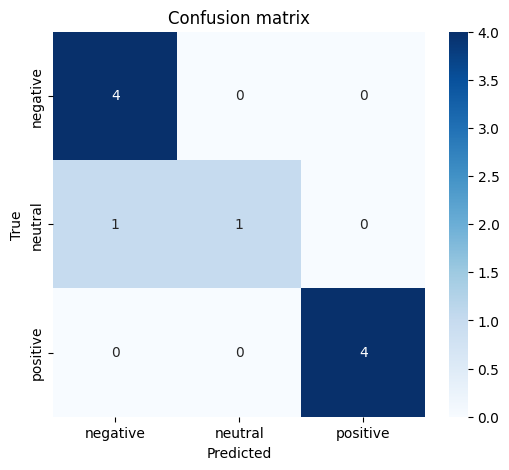

In [94]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_true_int = np.argmax(y_test, axis=1)

print(classification_report(y_true_int, y_pred_int, target_names=encoder.classes_))  # includes precision/recall/F1

cm = confusion_matrix(y_true_int, y_pred_int)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [95]:
from sklearn.metrics import f1_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1s = []

for train_idx, val_idx in skf.split(padded, y_int):
    X_tr, X_val = padded[train_idx], padded[val_idx]
    y_tr, y_val = y_cat[train_idx], y_cat[val_idx]

    m = build_model(vocab_size=vocab_size, max_len=max_len, num_classes=num_classes,
                    use_glove=use_glove, embedding_matrix=embedding_matrix if use_glove else None,
                    embedding_dim=128)

    m.fit(X_tr, y_tr, epochs=20, batch_size=16, verbose=0,
          validation_data=(X_val, y_val),
          class_weight=class_weight_dict,
          callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)])

    y_val_pred = m.predict(X_val, verbose=0)
    y_val_pred_int = np.argmax(y_val_pred, axis=1)
    y_val_int = np.argmax(y_val, axis=1)
    f1 = f1_score(y_val_int, y_val_pred_int, average="macro")
    f1s.append(f1)

print("Macro F1 across folds:", f1s)
print("Mean Macro F1:", np.mean(f1s), "±", np.std(f1s))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Macro F1 across folds: [0.6746031746031745, 0.8518518518518517, 0.669047619047619, 0.7777777777777777, 0.7746031746031746]
Mean Macro F1: 0.7495767195767196 ± 0.06926441264411703


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=le.classes_))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       1.00      1.00      1.00         9
    positive       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



In [96]:
samples = [
    "The app keeps crashing when I open it.",
    "Great service, thank you!",
    "Can I get a refund for my purchase?",
]
seq = tokenizer.texts_to_sequences(samples)
pad = pad_sequences(seq, maxlen=max_len, padding="post")
pred = model.predict(pad)
for s, p in zip(samples, pred):
    print(f"{s} -> {encoder.classes_[np.argmax(p)]} (probs={np.round(p,3)})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The app keeps crashing when I open it. -> negative (probs=[0.994 0.003 0.003])
Great service, thank you! -> positive (probs=[0.001 0.001 0.999])
Can I get a refund for my purchase? -> neutral (probs=[0.022 0.977 0.   ])
